# **Load in the data**

In [ ]:
pip install tensorflow tensorflow-gpu pandas matplpotlib sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement matplpotlib (from versions: none)
ERROR: No matching distribution found for matplpotlib


In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"mridusmitasingha","key":"8c2c8c3743e4746f6845c0199d0dda15"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 99% 52.0M/52.6M [00:03<00:00, 24.1MB/s]
100% 52.6M/52.6M [00:03<00:00, 17.1MB/s]


In [3]:
! unzip jigsaw-toxic-comment-classification-challenge

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [4]:
! unzip test.csv
! unzip test_labels.csv
! unzip train.csv
! unzip sample_submission.csv

Archive:  test.csv.zip
  inflating: test.csv                
Archive:  test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [5]:
file = "/content/train.csv"
df = pd.read_csv(file)

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


## 1. Prepocessing



In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['comment_text']
Y = df[df.columns[2:]].values

In [8]:
MAX_FEATURES = 200000 #number of words in the vocab

In [9]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [10]:
vectorizer.adapt(X.values)

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,Y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [14]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [15]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# Create Sequential Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [17]:
model = Sequential()
#Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
#Create a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final Layer
model.add(Dense(6, activation='sigmoid'))

In [18]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [20]:
history = model.fit(train, epochs=10, validation_data=val)

6981/6981 [==============================] - 10050s 1s/step - loss: 0.0618 - val_loss: 0.0448


In [24]:
history.history

{'loss': [0.06177816912531853], 'val_loss': [0.04476375877857208]}

In [21]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

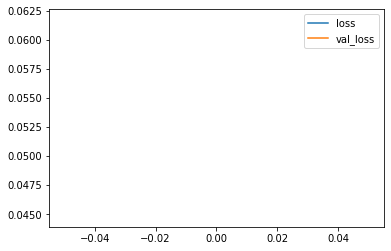

In [23]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Make Predictions

In [25]:
input_text = vectorizer('You freaking sucks! I am going to hit you')

In [26]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 1s 1s/step


In [27]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [28]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [29]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 199ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# Evaluate Model

In [31]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  #Unpack the batch
  X_true, y_true = batch
  #Make a prediction
  yhat = model.predict(X_true)

  #Flatten the predictions
  y_true = y_true.flatten()
  yhat = yhat.flatten()

  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)

In [35]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8443649411201477, Recall:0.6481735706329346, Accuracy:0.47342026233673096


# Test and Gradio

In [ ]:
!pip install gradio jinja2

In [37]:
import gradio as gr

In [38]:
model.save('toxicity.h5')

In [39]:
model = tf.keras.models.load_model('toxicity.h5')

In [40]:
input_str = vectorizer('hey i fucking hate you!')

In [41]:
res = model.predict(np.expand_dims(input_str, 0))

1/1 [==============================] - 1s 1s/step


In [42]:
res

array([[0.99558043, 0.19314061, 0.95409554, 0.04140693, 0.78923064,
        0.12931308]], dtype=float32)

In [43]:
def score_comment(comment):
  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text = ''
  for idx, col in enumerate(df.column[2:]):
    text += '{}: {}\n'.format(col, results[0][idx]>0.5)

  return text

In [ ]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                         outputs='text')

In [ ]:
interface.launch(share=True)